In [1]:
import pandas as pd
from utils.baseline_script import (
    prepare_data,
    run_experiment)

# save the patients_df
df = pd.read_csv('./data/msk_2024_fe_15.csv')
os_months_index = df.columns.get_loc("OS_MONTHS")

gene_mutations = df.iloc[:, :os_months_index]  # Exclude the first column (ID) and OS_MONTHS
data_labels = df.iloc[:, os_months_index:]  # Include only the OS_MONTHS column as labels

2025-04-22 06:35:59.629273: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745318159.656488   32511 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745318159.664765   32511 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-22 06:35:59.697964: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_loader, val_loader, test_loader, input_dim, all_columns = prepare_data(
    gene_mutations,
    data_labels,
    device = device,
    batch_size = 3000,
    whole_dataset = True
)

Train Size: torch.Size([15598, 980]), Validation Size: torch.Size([3343, 980]), Test Size: torch.Size([3343, 980])


Using model: MLP with input dimension: 980
Starting training for 100 epochs...
New best model found at epoch 1 with validation loss: 7.5312 and C-Index: 0.5679
New best model found at epoch 2 with validation loss: 7.5287 and C-Index: 0.6138
New best model found at epoch 3 with validation loss: 7.5259 and C-Index: 0.6462
New best model found at epoch 4 with validation loss: 7.5228 and C-Index: 0.6673
New best model found at epoch 5 with validation loss: 7.5194 and C-Index: 0.6810
New best model found at epoch 6 with validation loss: 7.5157 and C-Index: 0.6901
New best model found at epoch 7 with validation loss: 7.5118 and C-Index: 0.6969
New best model found at epoch 8 with validation loss: 7.5077 and C-Index: 0.7022
New best model found at epoch 9 with validation loss: 7.5034 and C-Index: 0.7065
Epoch 10/100, Train Loss: 8.8044, Val Loss: 7.4989, C-Index: 0.7102
New best model found at epoch 10 with validation loss: 7.4989 and C-Index: 0.7102
New best model found at epoch 11 with vali

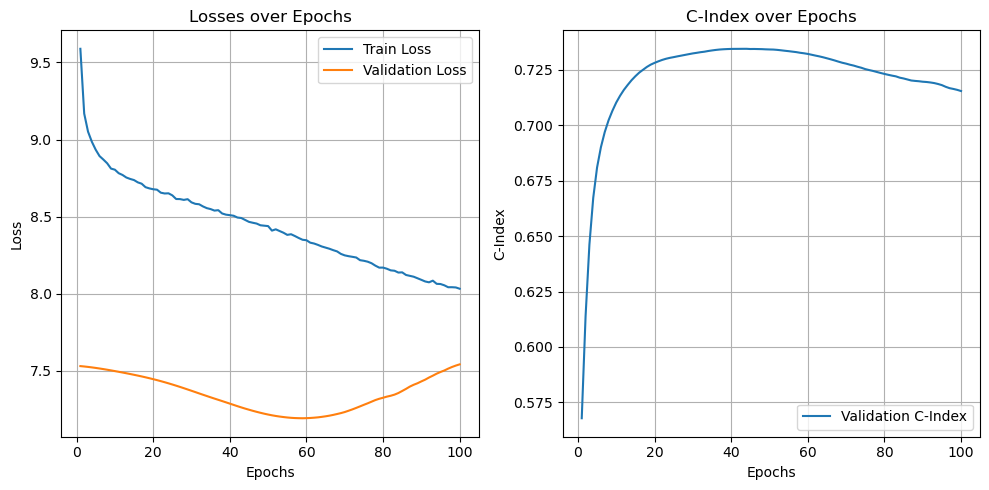

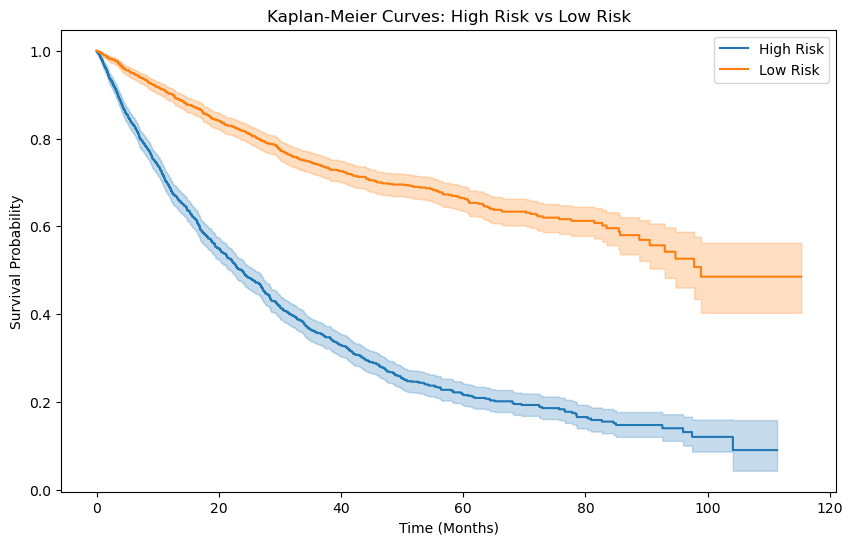

Log-rank test p-value: 1.0356561470317865e-126
Test Loss: 7.5065, Test c-index: 0.7127


In [3]:
train_losses, val_losses, val_c_indices, c_index_whole, model, best_model = run_experiment(
                                                                                            train_loader,
                                                                                            val_loader,
                                                                                            test_loader,
                                                                                            device = device,
                                                                                            ds_model = 'MLP',
                                                                                            ds_epoch = 100,
                                                                                            input_dim = input_dim[1],
                                                                                            ds_lr = 0.001,
                                                                                            ds_l2_reg = 1e-4,
                                                                                            fig_save_path = None,
                                                                                            test_results_saving_path = None,
                                                                                            model_save_path = None,
                                                                                            verbose=True
                                                                                        )

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from captum.attr import IntegratedGradients

# convert the test loader to tensor
X_test = []

for data in test_loader:
    X_test.append(data[0].to(device))
X_test = torch.cat(X_test, dim=0)  # shape: [num_samples, num_genes]

sample_input = X_test[0:1]  # shape: [1, num_genes]
sample_input = sample_input.to(device)
baseline = torch.zeros_like(sample_input)

# Instantiate the IntegratedGradients object with your model.
ig = IntegratedGradients(model)

# Compute attributions.
# For regression outputs, 'target' can be set to 0 (since risk score is a single output).
attributions, delta = ig.attribute(sample_input,
                                   baseline,
                                   target=0,
                                   return_convergence_delta=True)

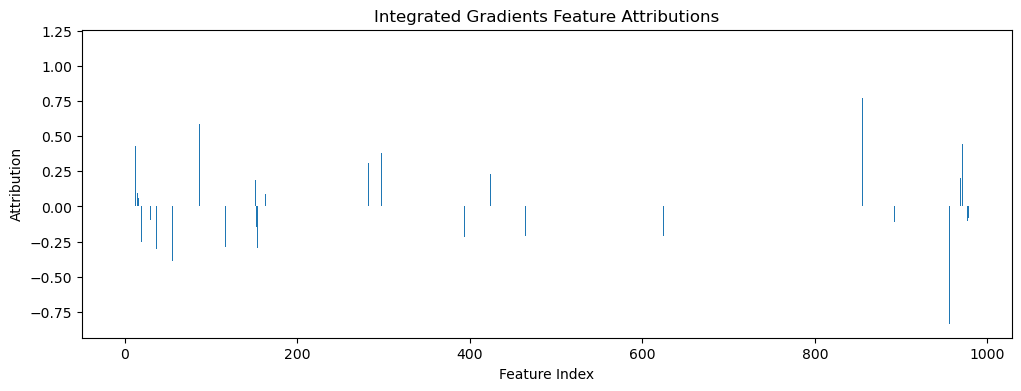

Convergence Delta: -0.01000346946135644


In [5]:
# Move attributions to CPU and convert to numpy.
attr_np = attributions.cpu().detach().numpy()[0]

# Optionally, you can normalize the attributions.
attr_norm = (attr_np - attr_np.min()) / (attr_np.max() - attr_np.min() + 1e-10)

# Plot the feature attributions.
plt.figure(figsize=(12, 4))
plt.bar(np.arange(len(attr_np)), attr_np)
plt.xlabel("Feature Index")
plt.ylabel("Attribution")
plt.title("Integrated Gradients Feature Attributions")
plt.show()

# Print convergence delta (a measure of approximation quality)
print("Convergence Delta:", delta.item())

Top 20 Features by Integrated Gradients:
CNS_BRAIN: Attribution = 1.1579, Absolute = 1.1579
AGO2_Frame_Shift_Del_DEL_chr8: Attribution = -0.8343, Absolute = 0.8343
FLT3_Splice_Site_SNP_chr13: Attribution = 0.7699, Absolute = 0.7699
TP53_Frame_Shift_Del_DEL_chr17: Attribution = 0.5877, Absolute = 0.5877
NRAS_Missense_Mutation_SNP_chr1: Attribution = 0.5220, Absolute = 0.5220
Distant: Attribution = 0.4436, Absolute = 0.4436
ERBB4_Missense_Mutation_SNP_chr2: Attribution = 0.4315, Absolute = 0.4315
DICER1_Missense_Mutation_SNP_chr14: Attribution = -0.3848, Absolute = 0.3848
SMO_Missense_Mutation_SNP_chr7: Attribution = 0.3782, Absolute = 0.3782
DOT1L_Missense_Mutation_SNP_chr19: Attribution = -0.3666, Absolute = 0.3666
ERCC2_Missense_Mutation_SNP_chr19: Attribution = 0.3107, Absolute = 0.3107
FLT3_Missense_Mutation_SNP_chr13: Attribution = -0.3036, Absolute = 0.3036
PIK3C3_Missense_Mutation_SNP_chr18: Attribution = -0.2923, Absolute = 0.2923
EGFR_Missense_Mutation_SNP_chr7: Attribution = -

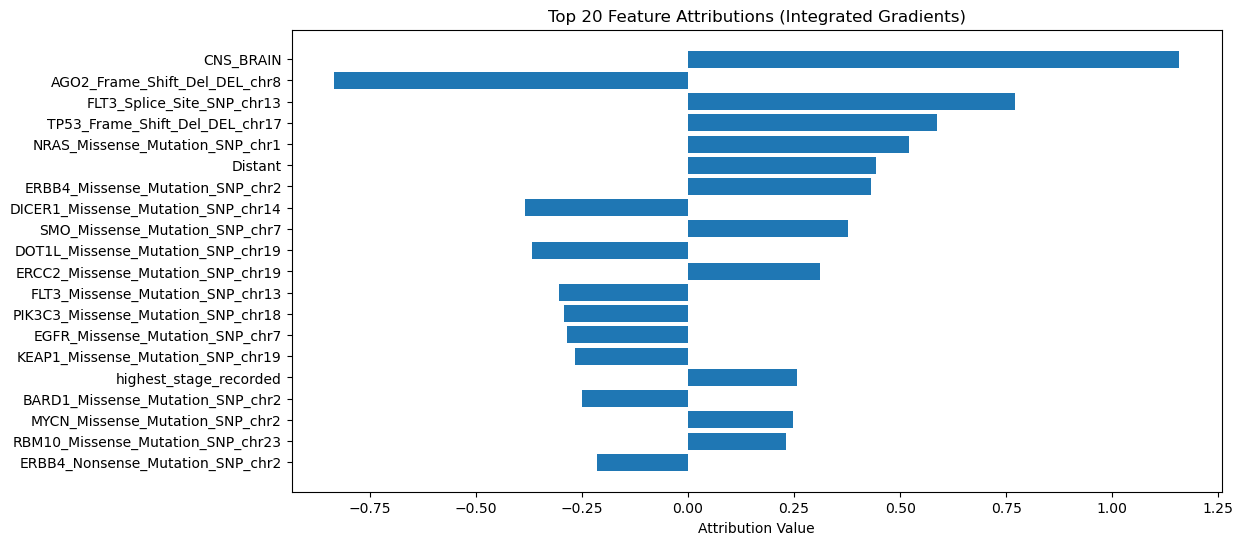

Convergence Delta: -0.01000346946135644


In [6]:
# Compute absolute values and get indices of the top 20 features.
abs_attr = np.abs(attr_np)
top_indices = np.argsort(abs_attr)[::-1][:20]

# Print the top 20 features along with their attributions.
print("Top 20 Features by Integrated Gradients:")
for idx in top_indices:
    print(f"{all_columns[idx]}: Attribution = {attr_np[idx]:.4f}, Absolute = {abs_attr[idx]:.4f}")

# Optionally, plot the attributions of the top features.
top_feature_names = [all_columns[idx] for idx in top_indices]
top_attr_values = attr_np[top_indices]

plt.figure(figsize=(12, 6))
plt.barh(top_feature_names[::-1], top_attr_values[::-1])
plt.xlabel("Attribution Value")
plt.title("Top 20 Feature Attributions (Integrated Gradients)")
plt.show()

print("Convergence Delta:", delta.item())



Top 20 global features by average absolute attribution:
Distant: Mean Abs Attribution = 0.5756
LIVER: Mean Abs Attribution = 0.4869
TMB_NONSYNONYMOUS: Mean Abs Attribution = 0.3517
CANCER_TYPE_BREAST: Mean Abs Attribution = 0.2828
CNS_BRAIN: Mean Abs Attribution = 0.2714
Regional: Mean Abs Attribution = 0.2560
FRACTION_GENOME_ALTERED: Mean Abs Attribution = 0.2363
CURRENT_AGE_DEID: Mean Abs Attribution = 0.1991
CANCER_TYPE_COLON: Mean Abs Attribution = 0.1880
LUNG: Mean Abs Attribution = 0.1792
KRAS_Missense_Mutation_SNP_chr12: Mean Abs Attribution = 0.1698
highest_stage_recorded: Mean Abs Attribution = 0.1042
CANCER_TYPE_LUNG: Mean Abs Attribution = 0.0890
TP53_Missense_Mutation_SNP_chr17: Mean Abs Attribution = 0.0873
APC_Nonsense_Mutation_SNP_chr5: Mean Abs Attribution = 0.0855
APC_Frame_Shift_Del_DEL_chr5: Mean Abs Attribution = 0.0635
CANCER_TYPE_PROSTATE: Mean Abs Attribution = 0.0606
CANCER_TYPE_PANCREAS: Mean Abs Attribution = 0.0511
PIK3CA_Missense_Mutation_SNP_chr3: Mean Abs

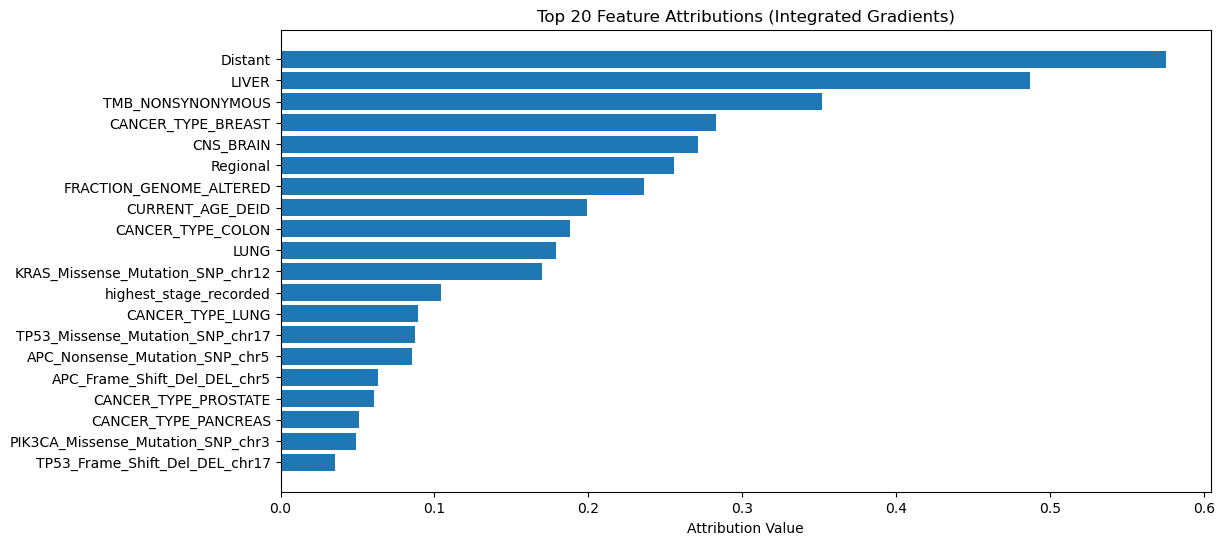

Convergence Delta: -0.01000346946135644


In [7]:
num_samples = len(X_test)
all_attrs = []
for i in range(num_samples):
    sample = X_test[i:i+1].to(device)
    attr, _ = ig.attribute(sample, baseline, target=0, return_convergence_delta=True)
    all_attrs.append(attr.cpu().detach().numpy()[0])
mean_attrs = np.mean(np.abs(np.array(all_attrs)), axis=0)

top_indices_global = np.argsort(mean_attrs)[::-1][:20]
print("\nTop 20 global features by average absolute attribution:")
for idx in top_indices_global:
    print(f"{all_columns[idx]}: Mean Abs Attribution = {mean_attrs[idx]:.4f}")

top_feature_gloabl_names = [all_columns[idx] for idx in top_indices_global]
top_attr_global_values = mean_attrs[top_indices_global]

plt.figure(figsize=(12, 6))
plt.barh(top_feature_gloabl_names[::-1], top_attr_global_values[::-1])
plt.xlabel("Attribution Value")
plt.title("Top 20 Feature Attributions (Integrated Gradients)")
plt.show()

print("Convergence Delta:", delta.item())